In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd

import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 

%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [3]:
def bin_by_spt_bin(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]

def iswithin_mag_limits(mags, pnt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k])
    return np.logical_or.reduce(flags)


def plot(NUMBERS, VOLUMES):
    # In[ ]:
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs)
    dy2=np.sqrt(y2)

    fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=True, sharex=False)
    for model, a in zip(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])*VOLUMES[idx]
            
            a.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns), 
                         where='mid', label='h={} pc'.format(h), color= cmap(cnorm(h/100)), linewidth=3)
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


    ax[0][0].set_title('Model= SM08', fontsize=18)
    ax[0][1].set_title('Model= B03', fontsize=18)
    ax[1][0].set_title('Model= Sonora', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[0][0].errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k', label='observations')
    ax[0][0].legend(fontsize=14, loc='upper right')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')

In [4]:
sgrid=wispsim.SPGRID
pnts=wisps.OBSERVED_POINTINGS

In [5]:
cands=pd.read_pickle(wisps.LIBRARIES+'/candidates.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [6]:
tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')
flags=[iswithin_mag_limits(x, y) for x, y in zip(obsmgs, tab.pnt.values)]

cdf_to_use=tab[flags]
nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']

In [7]:
NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl.gz')

In [8]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

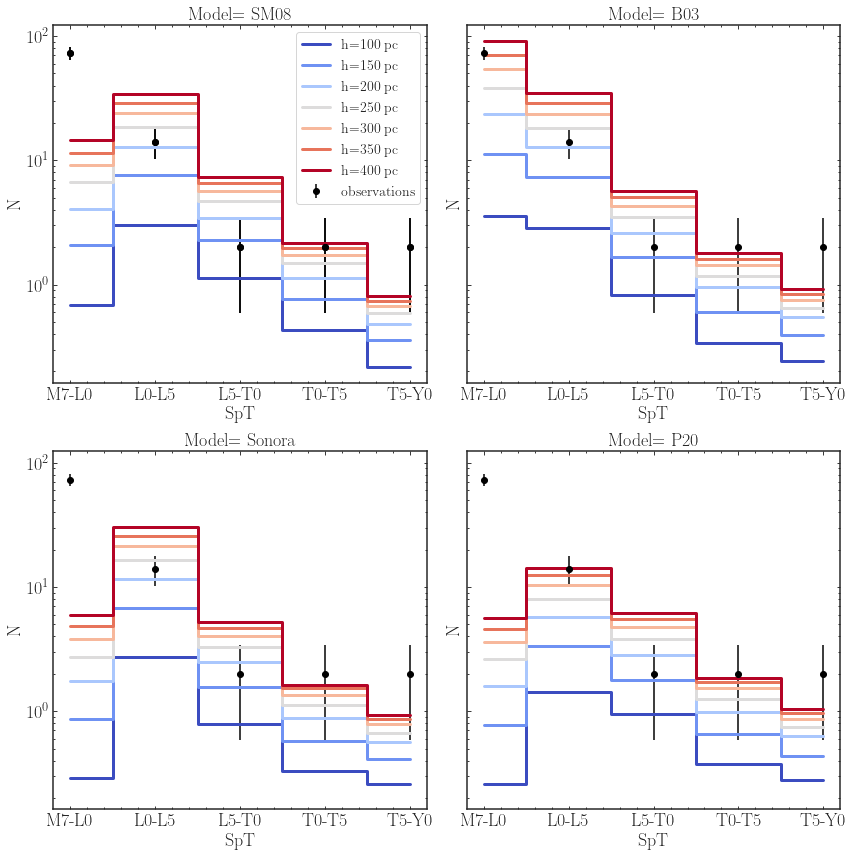

In [9]:
 plot(NUMBERS, VOLUMES)

In [22]:
y2=bin_by_spt_bin(wispsim.SPGRID,nobs)

In [23]:
#PRINT THE BEST FIT NUMBER 
best_fit={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_fit={}
        for idx, h in enumerate(wispsim.HS):
            ns=None
            ns=np.array(((NUMBERS[model])[idx])*VOLUMES[idx])
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns))
            #compute chi-squared
            #print (ns)
            chisq= (y2-binned)**2/(y2)
            model_fit.update({h: chisq})
        best_fit.update({model: model_fit})

In [24]:
chisq_dicts=pd.DataFrame.from_records(best_fit)

In [25]:
import splat

In [26]:
min_chi_ssqrs={}
for c in chisq_dicts.columns:
    min_vals={}
    for idx,s  in enumerate(spgrid2):
        #compare between subtypes
        vals=(np.vstack(chisq_dicts[c].values))

        mean, unc=splat.weightedMeanVar(np.array(chisq_dicts.index), vals[:,idx], method='ftest',dof=1)
        
        min_vals.update({s:[np.round(mean), np.round(unc)]})
        #final minimal
        print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc)))
        
    min_chi_ssqrs.update({c:min_vals})
    

 scale height for model baraffe2003 and spt M7-L0 is 350.0 +/- 5.0 
 scale height for model baraffe2003 and spt L0-L5 is 201.0 +/- 13.0 
 scale height for model baraffe2003 and spt L5-T0 is 161.0 +/- 30.0 
 scale height for model baraffe2003 and spt T0-T5 is 379.0 +/- 43.0 
 scale height for model baraffe2003 and spt T5-Y0 is 285.0 +/- 95.0 
 scale height for model marley2019 and spt M7-L0 is 256.0 +/- 100.0 
 scale height for model marley2019 and spt L0-L5 is 224.0 +/- 35.0 
 scale height for model marley2019 and spt L5-T0 is 174.0 +/- 37.0 
 scale height for model marley2019 and spt T0-T5 is 351.0 +/- 63.0 
 scale height for model marley2019 and spt T5-Y0 is 285.0 +/- 95.0 
 scale height for model phillips2020 and spt M7-L0 is 255.0 +/- 100.0 
 scale height for model phillips2020 and spt L0-L5 is 400.0 +/- 5.0 
 scale height for model phillips2020 and spt L5-T0 is 151.0 +/- 13.0 
 scale height for model phillips2020 and spt T0-T5 is 386.0 +/- 34.0 
 scale height for model phillips202

In [27]:
pd.DataFrame(min_chi_ssqrs)

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"[350.0, 5.0]","[256.0, 100.0]","[255.0, 100.0]","[265.0, 100.0]"
L0-L5,"[201.0, 13.0]","[224.0, 35.0]","[400.0, 5.0]","[201.0, 13.0]"
L5-T0,"[161.0, 30.0]","[174.0, 37.0]","[151.0, 13.0]","[148.0, 16.0]"
T0-T5,"[379.0, 43.0]","[351.0, 63.0]","[386.0, 34.0]","[352.0, 14.0]"
T5-Y0,"[285.0, 95.0]","[285.0, 95.0]","[291.0, 93.0]","[278.0, 96.0]"


In [28]:
def propagate_uncertainties(row):
    vals=np.vstack(row.values)[:,0]
    uncs=np.vstack(row.values)[:,1]
    
    return round(np.nanmean(vals)), round(np.sqrt(np.nansum(uncs**2)))

In [29]:
pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1)

M7-L0    (282.0, 173.0)
L0-L5     (256.0, 40.0)
L5-T0     (158.0, 52.0)
T0-T5     (367.0, 85.0)
T5-Y0    (285.0, 190.0)
dtype: object

In [30]:
spectra=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl.gz')

In [31]:
spts=np.array([x.spectral_type[0] for x in spectra])

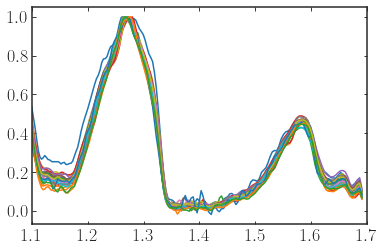

In [32]:
for x in spectra[spts==36]:
    plt.plot(x.wave, x.flux)
    plt.xlim([1.1, 1.7])

In [ ]:
#use my velocity dispersion converter 
